<a href="https://colab.research.google.com/github/Addy48/Aaditya_Upadhyay_23FE10CSE00457_MLLab/blob/main/MLSelfProjectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment: Used Cars Price Prediction (Lab 1 & Lab 2)

**Dataset path:** `/content/used_cars_dataset_v2.csv`

### Objective
We aim to predict the price of used cars using regression techniques.

### What this notebook will accomplish
- Load and clean the used-cars dataset (convert `AskPrice` to numeric, `kmDriven` to numeric, handle missing values).
- Perform Exploratory Data Analysis (data types, summary statistics, correlations, pairplots).
- One-hot encode categorical attributes for regression.
- Train and evaluate Linear Regression model using price as the target.
- Examine model coefficients, standard errors, t-statistics, and empirical CDF.
- Evaluate performance using MAE, SSE, RMSE, and R².
- Implement MinMax normalization as required in Lab 2.

### Target Variable
`AskPrice` (in Indian Rupees).

### Lab Mapping
- **Lab 1:** EDA + Regression Modeling + Coef Analysis + Metrics.
- **Lab 2:** MinMax normalization + scaled comparison.

### Notes
- This dataset replaces the Housing dataset mentioned in the original lab PDF.
- PDF reference from assignment instructions was provided separately.


In [16]:
# Lab 1 — Task: Imports, load, initial cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For reproducibility
RANDOM_STATE = 42

# Load
path = "/content/used_cars_dataset_v2.csv"
df = pd.read_csv(path)

# Quick preview
print("Shape:", df.shape)
display(df.head())

# Basic cleaning functions
def clean_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = s.replace('₹', '').replace('Rs.', '').replace(',', '').strip()
    # handle weird spacing
    s = ''.join(ch for ch in s if ch.isdigit())
    return int(s) if s else np.nan

def clean_km(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = s.replace('km', '').replace(',', '').strip()
    s = ''.join(ch for ch in s if (ch.isdigit() or ch=='.'))
    try:
        return float(s) if s else np.nan
    except:
        return np.nan

# Applying cleaning
df['AskPrice_raw'] = df['AskPrice']   # keep raw
df['AskPrice'] = df['AskPrice'].apply(clean_price)
df['kmDriven_raw'] = df['kmDriven']
df['kmDriven'] = df['kmDriven'].apply(clean_km)

# Year/Age consistency check
if 'Year' in df.columns and 'Age' in df.columns:
    print("Year range:", df['Year'].min(), "-", df['Year'].max())
    print("Age range:", df['Age'].min(), "-", df['Age'].max())

# Drop columns not used for baseline
drop_cols = ['AdditionInfo', 'AskPrice_raw', 'kmDriven_raw', 'PostedDate']
for c in drop_cols:
    if c in df.columns:

        pass

display(df.dtypes)


Shape: (14993, 11)


,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","₹ 1,95,000"
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","₹ 3,75,000"
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","₹ 1,84,999"
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"₹ 5,65,000"
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","₹ 6,85,000"


Year range: 1900 - 2024
Age range: 0 - 124


,0
Brand,object
model,object
Year,int64
Age,int64
kmDriven,float64
Transmission,object
Owner,object
FuelType,object
PostedDate,object
AdditionInfo,object


In [15]:
# Lab 1 — Task: dtypes, summary, column names, extended describe
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
display(df[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9]).T)


print("\nMissing value counts:")
display(df.isnull().sum())


Columns: ['Brand', 'model', 'Year', 'Age', 'kmDriven', 'Transmission', 'Owner', 'FuelType', 'PostedDate', 'AdditionInfo', 'AskPrice', 'AskPrice_raw', 'kmDriven_raw']

Data types:
 Brand            object
model            object
Year              int64
Age               int64
kmDriven        float64
Transmission     object
Owner            object
FuelType         object
PostedDate       object
AdditionInfo     object
AskPrice          int64
AskPrice_raw     object
kmDriven_raw     object
dtype: object

Numeric columns: ['Year', 'Age', 'kmDriven', 'AskPrice']


,count,mean,std,min,25%,50%,75%,90%,max
Year,14993.0,2016.322150,4.343017e+00,1900.0,2014.0,2017.0,2019.0,2022.0,2024.0
Age,14993.0,7.677850,4.343017e+00,0.0,5.0,7.0,10.0,13.0,124.0
kmDriven,14905.0,71078.347601,5.745829e+04,0.0,44000.0,65200.0,86000.0,115000.0,980002.0
AskPrice,14993.0,997017.496031,1.586640e+06,15000.0,349000.0,570000.0,1025000.0,1995000.0,42500000.0



Missing value counts:


,0
Brand,0
model,0
Year,0
Age,0
kmDriven,88
Transmission,0
Owner,0
FuelType,0
PostedDate,0
AdditionInfo,0


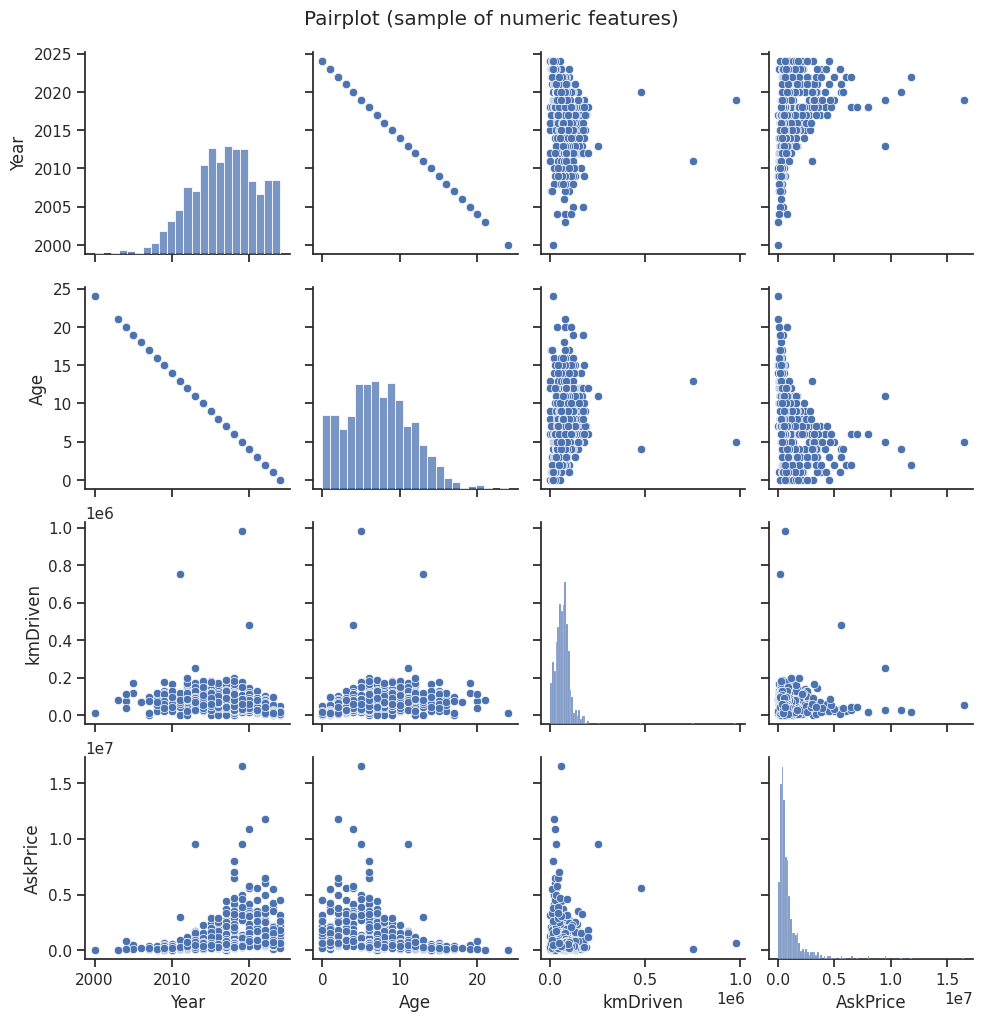

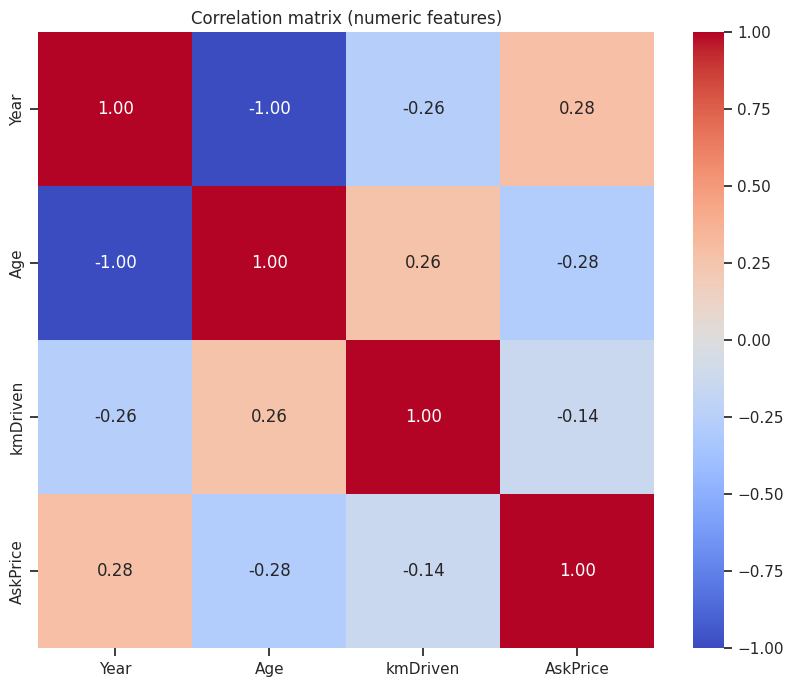

In [14]:
# Lab 1 — Task: Pairplot & correlation heatmap
sns.set(style="ticks", rc={"figure.figsize":(10,8)})
sample = df[numeric_cols].dropna().sample(n=min(800, df.shape[0]), random_state=RANDOM_STATE)
sns.pairplot(sample)
plt.suptitle("Pairplot (sample of numeric features)", y=1.02)
plt.show()

# Correlation matrix & heatmap
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix (numeric features)")
plt.show()


In [18]:
# Lab 1 — Task: Prepare X (features) and y (AskPrice)
# Select baseline features
# Keep numeric basics: Age, kmDriven, Year (optional). But to avoid multicollinearity we drop Year because is Age provided.
features = []
if 'Age' in df.columns:
    features.append('Age')
if 'kmDriven' in df.columns:
    features.append('kmDriven')
# include Year only if Age is not present
if 'Year' in df.columns and 'Age' not in df.columns:
    features.append('Year')

categorical_cols = [c for c in ['Brand','model','Transmission','FuelType','Owner'] if c in df.columns]

print("Numeric features:", features)
print("Categorical features (one-hot):", categorical_cols)

# Building DataFrame with selected columns
df_model = df[features + categorical_cols + ['AskPrice']].copy()
df_model = df_model.dropna(subset=['AskPrice'])  # drop rows without target
print("Rows remaining after dropping NaN target:", df_model.shape[0])

display(df_model.isnull().sum())

df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=False)
print("Encoded shape:", df_encoded.shape)
display(df_encoded.head())


Numeric features: ['Age', 'kmDriven']
Categorical features (one-hot): ['Brand', 'model', 'Transmission', 'FuelType', 'Owner']
Rows remaining after dropping NaN target: 14993


,0
Age,0
kmDriven,88
Brand,0
model,0
Transmission,0
FuelType,0
Owner,0
AskPrice,0


Encoded shape: (14993, 490)


,Age,kmDriven,AskPrice,Brand_Ambassador,Brand_Ashok,Brand_Aston Martin,Brand_Audi,Brand_BMW,Brand_Bajaj,Brand_Bentley,...,model_maruti-suzuki-dzire,model_tata-punch,Transmission_Automatic,Transmission_Manual,FuelType_Diesel,FuelType_Hybrid/CNG,FuelType_Petrol,FuelType_hybrid,Owner_first,Owner_second
0,23,98000.0,195000,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
1,15,190000.0,375000,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,True
2,14,77246.0,184999,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False
3,7,83500.0,565000,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,True
4,5,45000.0,685000,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False


In [21]:
# Lab 1 — Task: Train-test split and fit models
X = df_encoded.drop(columns=['AskPrice'])
y = df_encoded['AskPrice'].astype(float)

# Optional: fill remaining NaNs in X (e.g., Age/km) with median
X = X.fillna(X.median())

# Convert boolean columns to integer (0 or 1) for statsmodels
# This addresses the 'Pandas data cast to numpy dtype of object' ValueError
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# SKLearn Linear Regression (prediction)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Statsmodels OLS for coefficients, std err, t-stat
X_sm = sm.add_constant(X)  # add intercept
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:               AskPrice   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     177.0
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:39:02   Log-Likelihood:            -2.2143e+05
No. Observations:               14993   AIC:                         4.437e+05
Df Residuals:                   14549   BIC:                         4.471e+05
Df Model:                         443                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

# Task
Calculate and report the Mean Absolute Error (MAE), Sum of Squared Errors (SSE), Root Mean Squared Error (RMSE), and R-squared (R²) for the Linear Regression model. Additionally, analyze the residuals by plotting their empirical Cumulative Distribution Function (CDF).

## evaluate_model_performance

### Subtask:
Calculate and report evaluation metrics for the Linear Regression model (MAE, SSE, RMSE, R²).


**Reasoning**:
To evaluate the Linear Regression model's performance, I will calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), Sum of Squared Errors (SSE), Root Mean Squared Error (RMSE), and R-squared (R²) using `y_test` and `y_pred` and then print them.



In [22]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
sse = mse * len(y_test)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Sum of Squared Errors (SSE): {sse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 286313.42
Sum of Squared Errors (SSE): 1196271285488459.00
Root Mean Squared Error (RMSE): 631577.44
R-squared (R²): 0.8026


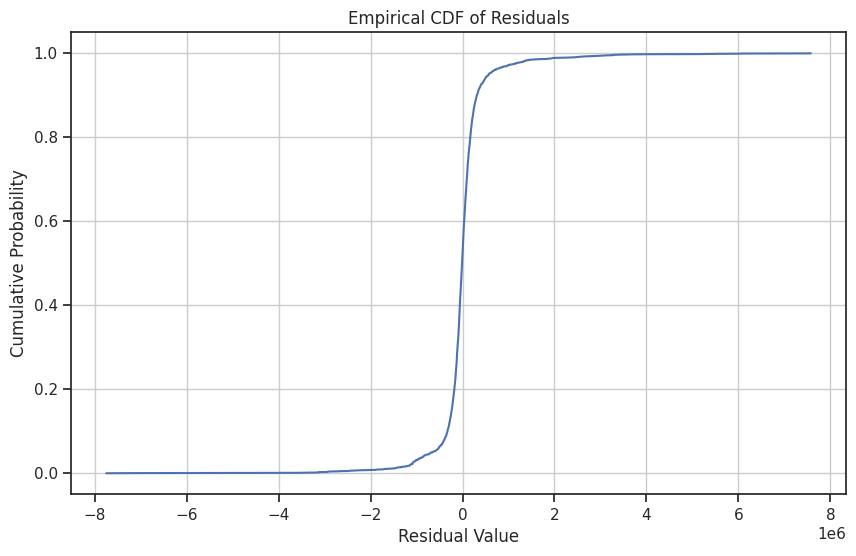

In [23]:
residuals = y_test - y_pred

# Calculate empirical CDF
sorted_residuals = np.sort(residuals)
cum_prob = np.arange(1, len(sorted_residuals) + 1) / len(sorted_residuals)

# Plot the empirical CDF
plt.figure(figsize=(10, 6))
plt.plot(sorted_residuals, cum_prob)
plt.title('Empirical CDF of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


## Summary:

### Q&A
The evaluation metrics for the Linear Regression model are as follows:
*  The Mean Absolute Error (MAE) is 286,313.42.
*  The Sum of Squared Errors (SSE) is 1,196,271,285,488,459.00.
*  The Root Mean Squared Error (RMSE) is 631,577.44.
*  The R-squared (R²) value is 0.8026.
Residuals were analyzed by calculating the differences between actual and predicted values and then plotting their empirical Cumulative Distribution Function (CDF).

### Data Analysis Key Findings
* The Linear Regression model achieved an R-squared (R²) value of 0.8026, indicating that approximately 80.26% of the variance in the target variable can be explained by the model.
* The Mean Absolute Error (MAE) for the model is 286,313.42, suggesting the average magnitude of errors in predictions.
* The Root Mean Squared Error (RMSE) is 631,577.44, providing a measure of the average magnitude of the errors, with larger errors having a disproportionately larger effect.
* The Sum of Squared Errors (SSE) is 1,196,271,285,488,459.00.
* An empirical Cumulative Distribution Function (CDF) plot of the residuals was successfully generated, which helps visualize the distribution of prediction errors.


,coef,std_err,t_value,p_value
model_Phantom Series II,2.713184e+07,474234.474661,57.211866,0.000000e+00
model_SL-Class,1.772378e+07,620898.217428,28.545394,1.971871e-174
model_Urus,1.742059e+07,314463.541690,55.397814,0.000000e+00
Brand_Lamborghini,1.742059e+07,314463.541690,55.397814,0.000000e+00
model_G Class,1.732134e+07,283333.530261,61.134110,0.000000e+00
model_Phantom Drop HeadCoupe,-1.548101e+07,474303.482308,-32.639467,1.400318e-225
model_AMG,1.473707e+07,620896.263167,23.735164,3.246379e-122
model_LX,1.374573e+07,332416.379598,41.350941,0.000000e+00
Brand_Rolls-Royce,1.165083e+07,295490.394476,39.428783,0.000000e+00
model_Vanquish,1.126208e+07,314436.003398,35.816766,2.536903e-269


,abs_coef,ecdf
0,0.910265,0.002041
1,176.110877,0.004082
2,3192.309933,0.006122
3,6363.983669,0.008163
4,9797.293896,0.010204
5,10048.808604,0.012245
6,11020.783393,0.014286
7,11687.899688,0.016327
8,11801.447140,0.018367
9,12930.817802,0.020408


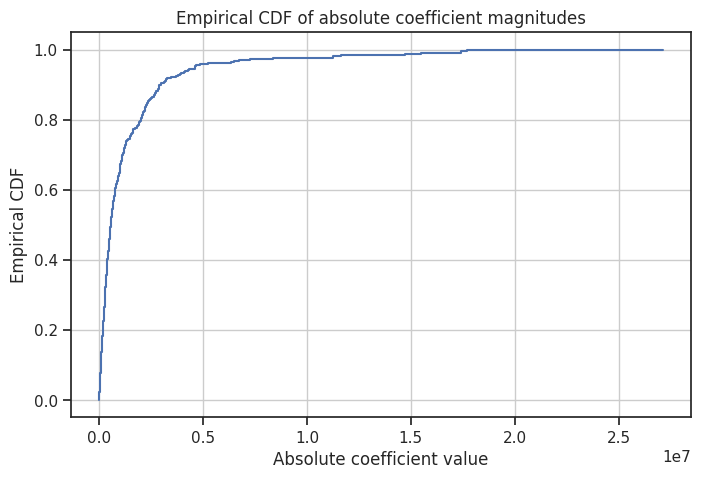

In [24]:
# Lab 1 — Task: Coefficients analysis and empirical CDF
params = model_sm.params.copy()
stderr = model_sm.bse
tvalues = model_sm.tvalues
pvalues = model_sm.pvalues

coef_table = pd.DataFrame({
    'coef': params,
    'std_err': stderr,
    't_value': tvalues,
    'p_value': pvalues
}).sort_values(by='coef', key=abs, ascending=False)

display(coef_table.head(20))

# Empirical CDF of absolute coefficient magnitudes
coef_vals = np.abs(params)
sorted_coef = np.sort(coef_vals)
ecdf = np.arange(1, len(sorted_coef)+1) / len(sorted_coef)
# Build table for sorted coefficients with ECDF
ecdf_df = pd.DataFrame({'abs_coef': sorted_coef, 'ecdf': ecdf})
display(ecdf_df.head(20))

# Plot ECDF of coefficients
plt.figure(figsize=(8,5))
plt.step(sorted_coef, ecdf, where='post')
plt.xlabel('Absolute coefficient value')
plt.ylabel('Empirical CDF')
plt.title('Empirical CDF of absolute coefficient magnitudes')
plt.grid(True)
plt.show()



MAE: ₹ 286,313.42
SSE: ₹ 1,196,271,285,488,459.00
RMSE: ₹ 631,577.44
R^2: 0.8026


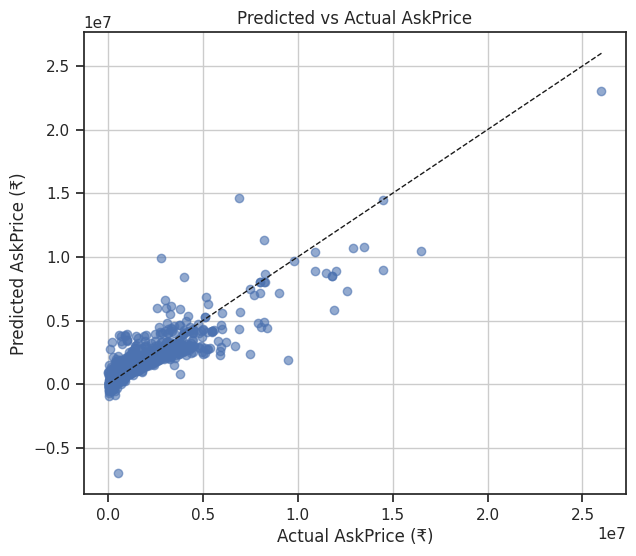

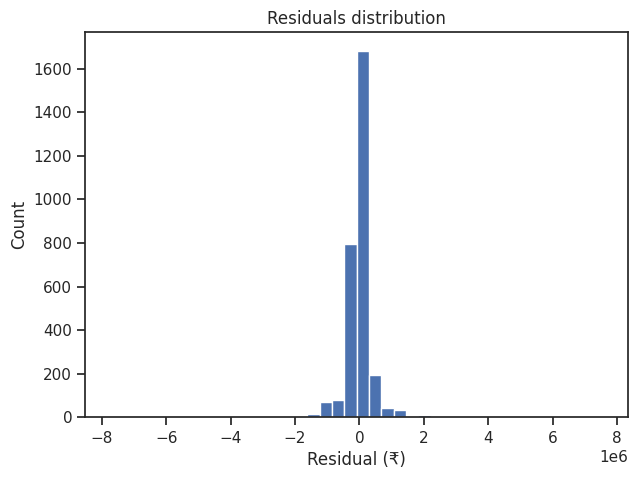

In [25]:
# Lab 1 — Task: Model evaluation (sklearn predictions) and plots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
sse = np.sum((y_test - y_pred)**2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: ₹ {mae:,.2f}")
print(f"SSE: ₹ {sse:,.2f}")
print(f"RMSE: ₹ {rmse:,.2f}")
print(f"R^2: {r2:.4f}")

# Predicted vs Actual scatter
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1)
plt.xlabel("Actual AskPrice (₹)")
plt.ylabel("Predicted AskPrice (₹)")
plt.title("Predicted vs Actual AskPrice")
plt.grid(True)
plt.show()

# Residuals histogram
residuals = (y_test - y_pred)
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40)
plt.title("Residuals distribution")
plt.xlabel("Residual (₹)")
plt.ylabel("Count")
plt.show()


##                           End of Lab 1